#### Default estimator and WoE binning
**RFMS model**

- RFM model is a classic customer stratification model, which uses the three core dimensions of the general transaction link-- Recency, Frequency and Monetary to segment customer groups.

**Steps to Implement:**

- **Data Preparation:**

    - Ensure the transaction data includes relevant columns like TransactionId, CustomerId, TransactionStartTime, and Amount.
- **Calculate Last Access Date:**

    - For each customer, find the most recent transaction date.
- **Calculate RFM Scores:**

    - Compute Recency, Frequency, and Monetary metrics using the above formulas

In [1]:
import os, sys
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [2]:
data = pd.read_csv("../data/extracted_features.csv")

In [3]:
from WoE import CreditScoreRFM
# Initialize RFMS object
rfm = CreditScoreRFM(data.reset_index())

Step 1: Calculate Recency, Frequency, and Monetary

In [4]:
# Step 1: Calculate Recency, Frequency, and Monetary
rfm_df = rfm.calculate_rfm()

# Display the first five rows
rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary']].head()

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_4406,2177,119,109921.75
2,CustomerId_4683,2257,2,1000.00
3,CustomerId_988,2181,38,228727.20
5,CustomerId_1432,2266,1,2000.00
6,CustomerId_2858,2181,29,93400.00


Visualize the RFM variables

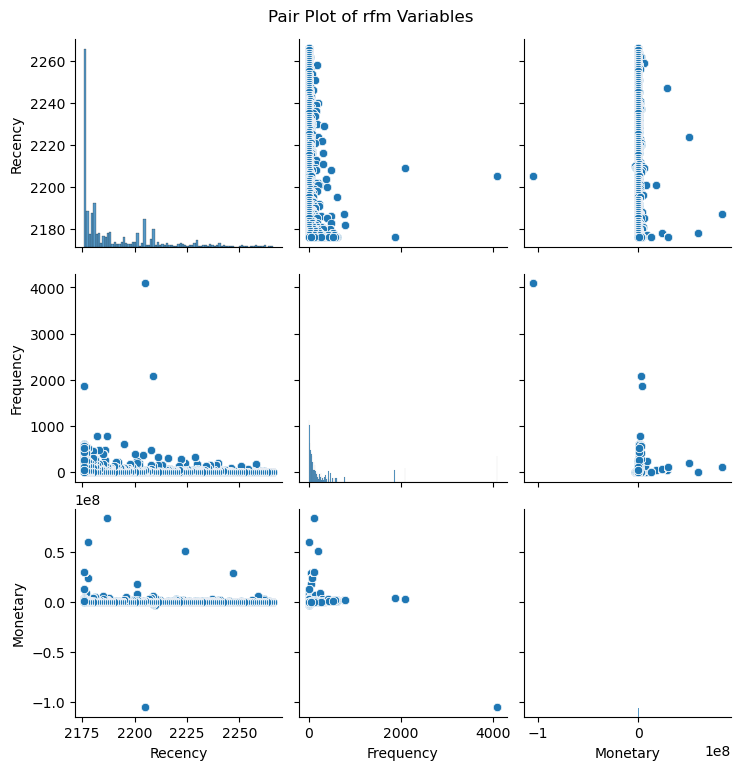

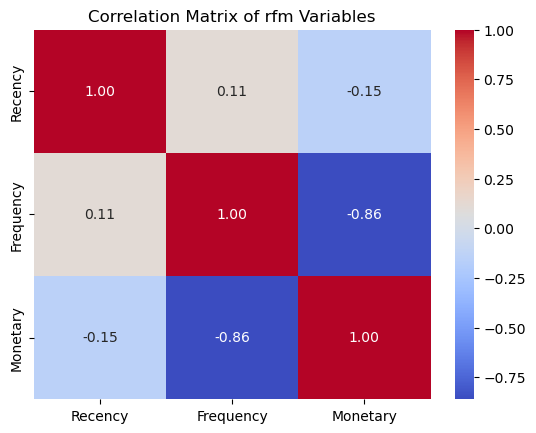

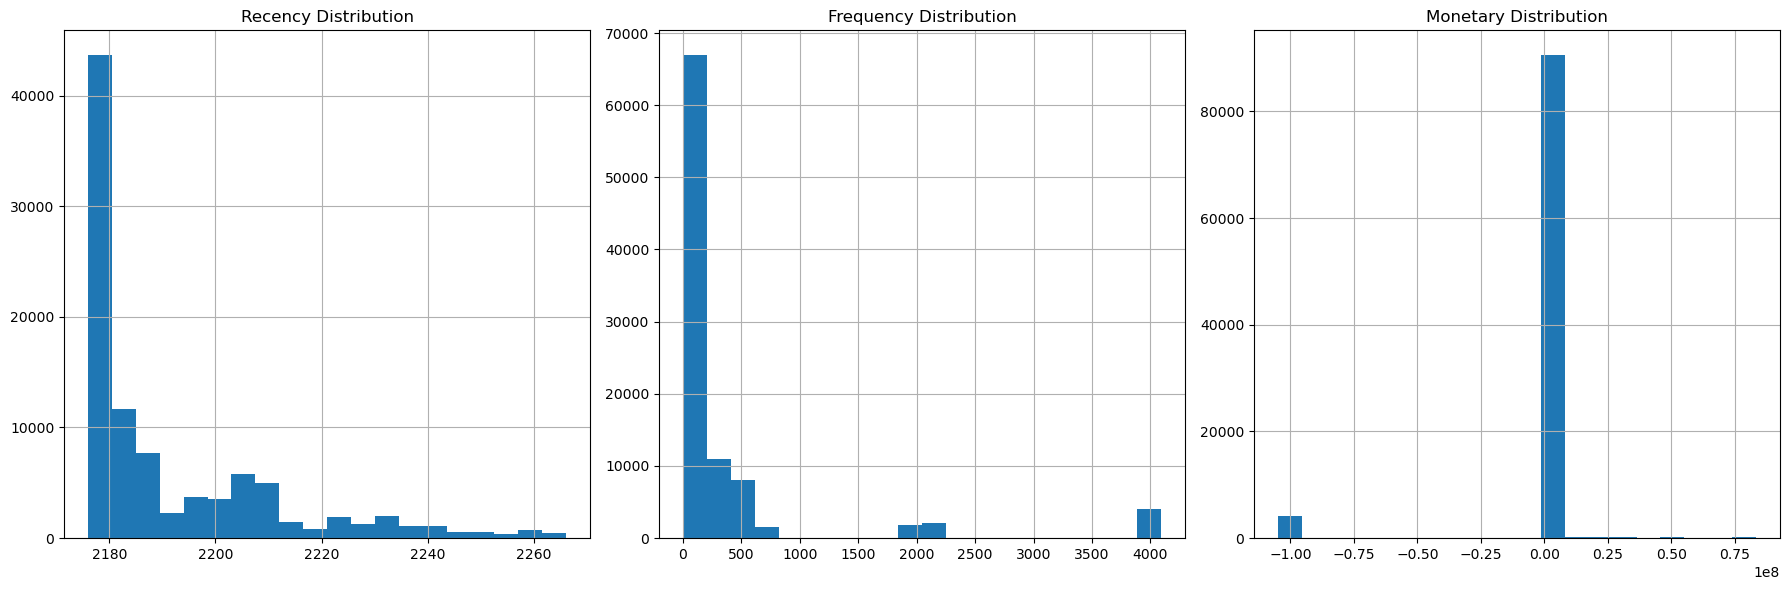

In [5]:
# Call the visualization functions
# Ensure rfms_df is defined and contains 'Recency', 'Frequency', 'Monetary', 'Risk_Level'
def visualize_rfm_data():
    """
    Function to run all RFMS visualizations.
    """
    rfm.plot_pairplot()
    rfm.plot_heatmap()
    rfm. plot_histograms()
 
visualize_rfm_data()

Calculate RFM score and assign bad or good labels

In [6]:
# Call the calculate_rfm_scores method to compute the overall RFM score

# Calculate RFM scores
rfm_df_scores = rfm.calculate_rfm_scores(rfm_df)


# Display the updated rfms_data DataFrame
rfm_df[['CustomerId',	'Recency',	'Frequency',	'Monetary',	'RFM_Score',	'Risk_Label']].head(10)

,CustomerId,Recency,Frequency,Monetary,RFM_Score,Risk_Label
0,CustomerId_4406,2177,119,109921.75,4.00,Good
2,CustomerId_4683,2257,2,1000.00,1.00,Bad
3,CustomerId_988,2181,38,228727.20,4.00,Good
5,CustomerId_1432,2266,1,2000.00,1.00,Bad
6,CustomerId_2858,2181,29,93400.00,4.00,Good
8,CustomerId_598,2264,4,8060.00,1.90,Bad
9,CustomerId_1053,2265,7,13788.00,1.90,Bad
10,CustomerId_3052,2237,12,10700.00,2.35,Good
16,CustomerId_3105,2176,199,159548.00,4.00,Good
19,CustomerId_3507,2216,11,6350.00,2.45,Good


Visualize the distribution of risk labels

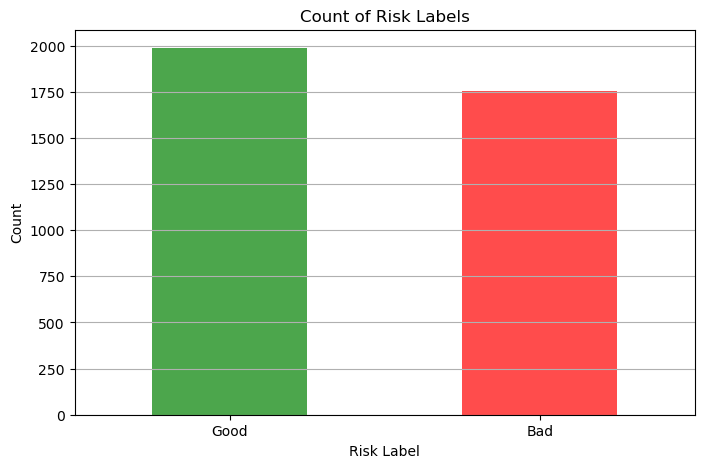

In [7]:
import matplotlib.pyplot as plt
# Count the occurrences of each risk label
risk_counts = rfm_df['Risk_Label'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
risk_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Risk Labels')
plt.xlabel('Risk Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y')

# Show the plot
plt.show()

Perform Weight of Evidence (WoE) binning

In [14]:
# Step 1: Create RFMS bins with unique edges
rfm_df['RFM_bin'] = pd.qcut(rfm_df['RFM_Score'], 5, labels=False, duplicates='drop')

# Step 2: Calculate good and bad counts
good_count, bad_count = rfm.calculate_counts(rfm_df)

# Step 3: Calculate WoE values
woe_values = rfm.calculate_woe(good_count, bad_count)[0]
# Create a mapping Series from the WoE values
woe_mapping = pd.Series(woe_values, index=good_count.index)

# Map WoE values back to the original DataFrame
rfm_df['RFM_woe'] = rfm_df['RFM_bin'].map(woe_mapping)


In [15]:
# Display the updated DataFrame
rfm_df[['RFM_Score', 'RFM_bin', 'Risk_Label', 'RFM_woe']].head(10)

,RFM_Score,RFM_bin,Risk_Label,RFM_woe
0,4.00,4,Good,21.891374
2,1.00,0,Bad,-22.223855
3,4.00,4,Good,21.891374
5,1.00,0,Bad,-22.223855
6,4.00,4,Good,21.891374
8,1.90,1,Bad,-22.307897
9,1.90,1,Bad,-22.307897
10,2.35,2,Good,1.430221
16,4.00,4,Good,21.891374
19,2.45,2,Good,1.430221


Visualize the result

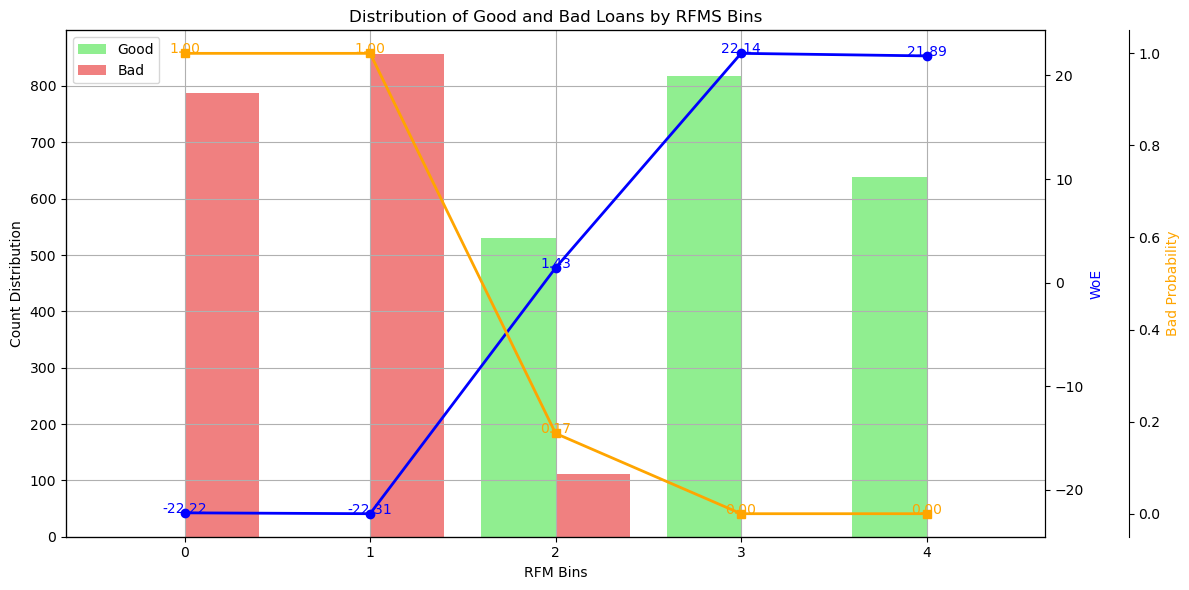

In [16]:
# Calculate Bad Probability
bad_probability = bad_count / (good_count + bad_count)

# Step 3: Prepare the DataFrame for plotting
plot_data = pd.DataFrame({
    'RFM_bin': good_count.index,
    'Good_Count': good_count.values,
    'Bad_Count': bad_count.values,
    'Bad_Probability': bad_probability.values,
    'RFM_woe': rfm_df.groupby('RFM_bin')['RFM_woe'].first().values
})

# Step 4: Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Good and Bad Counts
bar_width = 0.4
index = plot_data['RFM_bin']

# Create bar plots for Good and Bad counts
bar1 = ax1.bar(index - bar_width/2, plot_data['Good_Count'], width=bar_width, label='Good', color='lightgreen')
bar2 = ax1.bar(index + bar_width/2, plot_data['Bad_Count'], width=bar_width, label='Bad', color='lightcoral')

ax1.set_xlabel('RFM Bins')
ax1.set_ylabel('Count Distribution')
ax1.set_title('Distribution of Good and Bad Loans by RFMS Bins')
ax1.legend(loc='upper left')

# Adding WoE line
ax2 = ax1.twinx()
ax2.plot(index, plot_data['RFM_woe'], color='blue', marker='o', label='WoE', linewidth=2)
ax2.set_ylabel('WoE', color='blue')

# Annotate WoE values on the line
for i, woe in enumerate(plot_data['RFM_woe']):
    ax2.text(index[i], woe, f'{woe:.2f}', color='blue', ha='center', fontsize=10)

# Adding Bad Probability
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis outwards
ax3.plot(index, plot_data['Bad_Probability'], color='orange', marker='s', label='Bad Probability', linewidth=2)
ax3.set_ylabel('Bad Probability', color='orange')

# Annotate Bad Probability values on the line
for i, prob in enumerate(plot_data['Bad_Probability']):
    ax3.text(index[i], prob, f'{prob:.2f}', color='orange', ha='center', fontsize=10)

# Show grid
ax1.grid(True)
ax1.set_xticks(index)
ax1.set_xticklabels(plot_data['RFM_bin'])
plt.tight_layout()
plt.show()